# Fonctions pour le calcul avec le maximum de la vraisemblance

## Lecture et nettoyage des données (code fourni)

In [180]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase, GaussianMixtures, IterTools, DelimitedFiles

In [173]:
train = CSV.read("ODtrain.csv")
n = size(train,1)
p = size(train,2)
dropmissing!(train, disallowmissing=true)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

#string mode
d = Array{String}(undef,n)
for i=1:length(str_mode)
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
end
train[:D_Mode_str] = d

#nearest between train, metro and downtown
d = Array{Float64}(undef,n)
for i=1:n
    d[i] = min(train[i,[:M_dist_train, :M_dist_metro, :M_dist_centre]]...) 
end
train[:M_nearest] = d

#time of departure rounded to nearest hour 
d = Array{Int64}(undef,n)
for i=1:n
    h = train[i, :D_HREDE]
    d[i] = (h % 100) > 30 ? h + 100 - h % 100 : h - h % 100
    if d[i] == 0
        d[i] = 1
    end
end
train[:D_HREDE] = d

categorical!(train, :D_Mode_str);

first(train,50)

,IPERE,Menage,M_AUTO,M_PERS,M_DOMSM,M_revenu,M_dist_train,M_dist_metro,M_dist_centre,M_emploiTC,P_RANG,P_SEXE,P_AGE,P_GRAGE,P_STATUT,P_PERMIS,D_HREDE,D_MOTIF,D_Mode,D_Mode_str,M_nearest
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Categorical…,Float64
1,9,1000013,2,3,110,6,7.71979,1.81961,9.44328,556670,2,1,47,10,1,1,700,1,1,Voiture,1.81961
2,17,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,1,1,46,10,3,1,600,4,2,Transport Collectif,2.35297
3,21,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,3,1,47,10,1,2,500,1,2,Transport Collectif,2.35297
4,31,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,7,1,21,5,3,2,700,4,2,Transport Collectif,2.35297
5,29,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,6,2,54,11,1,1,600,1,1,Voiture,2.35297
6,25,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,5,1,56,12,1,1,600,1,1,Voiture,2.35297
7,23,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,4,1,63,13,1,2,700,1,4,Actif,2.35297
8,19,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,2,2,15,4,3,5,800,4,4,Actif,2.35297
9,39,1000016,0,1,406,2,3.12452,0.689126,12.9415,658600,1,1,32,7,1,1,800,1,2,Transport Collectif,0.689126


## Analyse des distributions des données

Ici on peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

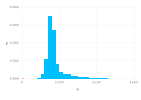

In [168]:
dep = 2; #1:voiture, 2:transport collectif, 3:voiture + transport collectif, 4:actif, 5 autre
sym = :D_HREDE
dist = Normal

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

## Fonctions pour le calcul

### Constante

In [78]:
k = 5
unique(train, :M_revenu)

,IPERE,Menage,M_AUTO,M_PERS,M_DOMSM,M_revenu,M_dist_train,M_dist_metro,M_dist_centre,M_emploiTC,P_RANG,P_SEXE,P_AGE,P_GRAGE,P_STATUT,P_PERMIS,D_HREDE,D_MOTIF,D_Mode,D_Mode_str
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Categorical…
1,9,1000013,2,3,110,6,7.71979,1.81961,9.44328,556670,2,1,47,10,1,1,730,1,1,Voiture
2,17,1000014,2,7,117,2,8.25894,2.35297,11.1385,318570,1,1,46,10,3,1,630,4,2,Transport Collectif
3,47,1000018,2,2,632,7,0.264051,18.4405,32.2865,19125,2,2,20,5,2,1,930,1,1,Voiture
4,51,1000020,1,2,511,1,28.4438,33.35,37.0521,13565,2,2,56,12,1,1,730,1,1,Voiture
5,59,1000024,3,4,651,4,14.0512,28.2821,44.4947,480,1,2,36,8,1,1,730,1,1,Voiture
6,80,1000039,1,2,130,3,2.5729,11.5405,16.5621,31935,2,2,56,12,1,1,800,1,1,Voiture
7,193,1000117,2,4,402,5,2.47278,13.8904,28.701,32760,1,2,46,10,1,1,550,1,1,Voiture
8,462,1000278,4,6,642,8,0.892372,14.1981,30.4107,35410,5,2,9,2,3,5,720,4,4,Actif


### Déclaration de types utilisés

In [56]:
struct MelangeNormales
    n::Int64
end

### Fonctions internes ("privées")

In [187]:
function determineMode(index::Int64, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = log(pdf(τ, i))
        for varExp in columns
           p[i] += log(pdf(dist[varExp][i], testSet[varExp][index]))
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end

function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    
    out = ""
    for i=1:k
        #print(str_mode[i], " : ", right[i]/nEach[i]*100, "%\n" ) 
        out *= str_mode[i] * " : " * string(right[i]/nEach[i]*100) * "%\n"
    end
    #print("Total : ", sum(right)/n*100, "%\n" )
    tot = sum(right)/n*100
    out *= "Total : " * string(tot) * "%\n"
    return (total=tot, output=out)
end

struct TestSet
    train::DataFrame
    test::DataFrame
end

function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end

function getEstimation(distType::Array{Any, 2}, columns::Array{Symbol, 1}, set::TestSet)
    # Maximum de la vraisemblance pour estimer
    nVariablesExpl = length(columns)
    for iVarExpl in 1:nVariablesExpl
        if !haskey(dist, columns[iVarExpl])
            dist[columns[iVarExpl]] = Array{Distribution}(undef, k)
            fitDistributions(distType[iVarExpl,:], columns[iVarExpl], set)
        end
    end
    amount = length(set.test[:IPERE])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, columns, set.test) 
    end
    return res
end

function fitDistributions(distType::Array{Any, 1}, varExpl::Symbol, set::TestSet)
    for mode=1:k
        trainT = set.train[set.train[:D_Mode] .== mode, :];
        if typeof(distType[mode]) == MelangeNormales
            gmm = GMM(distType[mode].n, trainT[varExpl]; method=:kmeans, nInit=100, nIter=20)
            dist[varExpl][mode] = MixtureModel(gmm)
        else
             # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
            dist[varExpl][mode] = fit_mle(distType[mode], trainT[varExpl])
        end
    end
end

fitDistributions (generic function with 2 methods)

### Fonction "publique"

In [199]:
function getPercentRight(distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    set = getTestSet(train)
    estimation = getEstimation(distType, columns, set)
    print(validate(estimation, set.test[:D_Mode]).output)
end

#Evaluates all the models made from the combinations of up to $maxNVars variables contained in $columns and returns the best one
function getBestModel(maxNVars::Int64, distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    #build the combinations of up to maxNVars
    subsetIndices = [] 
    for i in 1:maxNVars
        append!(subsetIndices, [j for j in subsets(1:length(columns), i)])
    end
    
    #generate the results for all models
    set = getTestSet(train)
    results = Array{NamedTuple}(undef, length(subsetIndices))
    for i in 1:length(subsetIndices)
        indices = subsetIndices[i]
        println("now testing: ", columns[indices])
        estimation = getEstimation(distType[indices, :], columns[indices], set)
        tot, out = validate(estimation, set.test[:D_Mode])
        results[i] = (total=tot, output=out, columns=columns[indices])
    end
    
    #rank models and return ranking
    sort!(results, by = x -> x.total, rev=true)
    print("Best model: ", results[1].columns, "\n", results[1].output)
    return results
end

function generateSubmission(distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    test = CSV.read("ODtest.csv")
    submission = test[:, [:IPERE]]
    set = TestSet(train, test)
    estimation = getEstimation(distType, columns, set)
    submission = DataFrame(IPERE = test[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmission (generic function with 2 methods)

### Exemple

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle.
On pense la même chose pour la variable P_STATUT.
Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma.

Pour les trois variables, nous avons donné la même distribution peut-importe la valeur de Y.
Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire:
Gamma Gamma Normal Gamma Gamma

Les fonctions ci-dessus séparent l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.
Le résultat de l'appel à getPercentRight est séparé selon le mode de transport.

In [196]:
#reset global known distributions
dist = Dict()

getPercentRight([
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Poisson Poisson Poisson Poisson Poisson];
        ], [
            :P_PERMIS,
            :P_AGE,
            :D_MOTIF,
            :D_HREDE,
            :M_DOMSM,
            :M_AUTO
        ])

Voiture : 82.51040221914009%
Transport Collectif : 48.432546671363156%
Hybride : 0.0%
Actif : 29.38701923076923%
Autre : 83.66606170598911%
Total : 65.89966050546964%


In [200]:
#reset global known distributions
dist = Dict()

generateSubmission([
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Poisson Poisson Poisson Poisson Poisson];
        ], [
            :P_PERMIS,
            :P_AGE,
            :D_MOTIF,
            :D_HREDE,
            :M_DOMSM,
            :M_AUTO
        ])

"Submission.csv"

In [174]:
#reset global known distributions
dist = Dict{}()

results = getBestModel(13,
        [
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
            [Poisson Poisson Poisson Poisson Poisson];
            [Gamma Gamma MelangeNormales(6) Gamma MelangeNormales(6)];
            [MelangeNormales(6) MelangeNormales(5) MelangeNormales(5) MelangeNormales(6) MelangeNormales(7)];
            [MelangeNormales(7) Gamma MelangeNormales(8) Gamma MelangeNormales(10)];
        ], [
            :P_PERMIS,
            :P_STATUT,
            :P_AGE,
            :P_GRAGE,
            :D_MOTIF,
            :D_HREDE,
            :M_PERS,
            :M_DOMSM,
            :M_dist_centre,
            :M_AUTO,
            :M_nearest,
            :M_dist_train,
            :M_dist_metro,
        ])

filename = "BruteForce$(rand(0:9999999)).txt"
writedlm(filename, results)
print("Full results saved to $filename")

now testing: Symbol[:P_PERMIS]
now testing: Symbol[:P_STATUT]
now testing: Symbol[:P_AGE]
now testing: Symbol[:P_GRAGE]
now testing: Symbol[:D_MOTIF]
now testing: Symbol[:D_HREDE]
now testing: Symbol[:M_PERS]
now testing: Symbol[:M_DOMSM]
now testing: Symbol[:M_dist_centre]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.476038e+04
      1       3.334396e+04  

┌ Info: Initializing GMM, 10 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28804 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


    -2.141642e+04 |       10
      2       3.126322e+04      -2.080740e+03 |       10
      3       3.029949e+04      -9.637287e+02 |        9
      4       2.966779e+04      -6.317077e+02 |       10
      5       2.907478e+04      -5.930068e+02 |       10
      6       2.858410e+04      -4.906753e+02 |        9
      7       2.822823e+04      -3.558771e+02 |        9
      8       2.796619e+04      -2.620403e+02 |       10
      9       2.772296e+04      -2.432241e+02 |       10
     10       2.752687e+04      -1.960956e+02 |        9
     11       2.740024e+04      -1.266322e+02 |        9
     12       2.728320e+04      -1.170380e+02 |       10
     13       2.717846e+04      -1.047338e+02 |        9
     14       2.708501e+04      -9.345694e+01 |       10
     15       2.701474e+04      -7.026309e+01 |        9
     16       2.696563e+04      -4.911659e+01 |        9
     17       2.693823e+04      -2.739368e+01 |        9
     18       2.691462e+04      -2.361757e+01 |        9
  

┌ Info: K-means with 10000 data points using 42 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.889599
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.864154
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.857391
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.854437
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.852837
└ @ GaussianMixtures C

  Iters  

┌ Info: iteration 13, average log likelihood -3.849671
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.849566
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.849478
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.849404
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.849340
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.849285
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.849237
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

             objv        objv-change | affected 
-------------------------------------------------------------
      0       2.327516e+04
      1       2.073121e+04      -2.543948e+03 |        7
      2       2.020916e+04      -5.220491e+02 |        7
      3       1.978226e+04      -4.269013e+02 |        7
      4       1.946946e+04      -3.127936e+02 |        7
      5       1.933426e+04      -1.352011e+02 |        7
      6       1.927321e+04      -6.105404e+01 |        7
      7       1.925596e+04      -1.724974e+01 |        5
      8       1.925008e+04      -5.884038e+00 |        6
      9       1.924565e+04      -4.421678e+00 |        6
     10       1.924344e+04      -2.209673e+00 |        5
     11       1.924255e+04      -8.904835e-01 |        5
     12       1.924187e+04      -6.812593e-01 |        6
     13       1.924163e+04      -2.396649e-01 |        3
     14       1.924155e+04      -8.288836e-02 |        2
     15       1.924151e+04      -3.807406e-02 |        2
     16

┌ Info: K-means with 7000 data points using 18 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.366537
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.340152
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.332703
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.329311
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.327384
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.561616e+04
      1       1.220175e+04      -3.414412e+03 |        7
      2       1.158597e+04      -6.157794e+02 |        7
      3       1.112161e+04      -4.643616e+02 |        7
      4       1.070102e+04      -4.205927e+02 |        6
      5       1.018683e+04      -5.141853e+02 |        6
      6       9.642379e+03      -5.444534e+02 |        6
      7       9.361336e+03      -2.810433e+02 |        6
      8       9.146741e+03      -2.145952e+02 |        7
      9       8.992241e+03      -1.544996e+02 |        5
     10       8.897789e+03      -9.445223e+01 |        6
     11       8.812658e+03      -8.513097e+01 |        5
     12       8.726422e+03      -8.623536e+01 |        6
     13       8.659097e+03      -6.732542e+01 |        7
     14       8.563155e+03      -9.594248e+01 |        7
     15       8.299670e+03      -2.634843e+02 |        

┌ Info: K-means with 1679 data points using 57 iterations
│ 119.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.704334
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.684574
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.679233
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.676989
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.675826
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.855242e+04
      1       2.697326e+04      -2.157916e+04 |        8
      2       2.373344e+04      -3.239827e+03 |        8
      3       2.207868e+04      -1.654755e+03 |        8
      4       2.145302e+04      -6.256590e+02 |        7
      5       2.118978e+04      -2.632447e+02 |        7
      6       2.103246e+04      -1.573153e+02 |        8
      7       2.090264e+04      -1.298218e+02 |        7
      8       2.083576e+04      -6.687613e+01 |        7
      9       2.078245e+04      -5.331517e+01 |        7
     10       2.075568e+04      -2.676680e+01 |        7
     11       2.074716e+04      -8.525599e+00 |        7
     12       2.074283e+04      -4.329270e+00 |        6
     13       2.073894e+04      -3.884413e+00 |        6
     14       2.073331e+04      -5.628160e+00 |        7
     15       2.072614e+04      -7.176229e+00 |        

┌ Info: K-means with 6683 data points using 29 iterations
│ 417.7 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.589113
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.565907
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.559384
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.556531
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.554973
└ @ GaussianMixtures C:\

  Iters               objv        objv-change

┌ Info: iteration 13, average log likelihood -3.551157
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.550895
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.550637
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.550379
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.550118
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.549855
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.549587
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

 | affected 
-------------------------------------------------------------
      0       1.885182e+04
      1       1.448059e+04      -4.371229e+03 |        9
      2       1.391264e+04      -5.679563e+02 |        9
      3       1.372946e+04      -1.831716e+02 |        8
      4       1.364840e+04      -8.106276e+01 |        8
      5       1.358854e+04      -5.986207e+01 |        7
      6       1.353734e+04      -5.119560e+01 |        6
      7       1.347404e+04      -6.330756e+01 |        7
      8       1.341500e+04      -5.903641e+01 |        6
      9       1.337728e+04      -3.771561e+01 |        7
     10       1.336666e+04      -1.062269e+01 |        4
     11       1.335466e+04      -1.200330e+01 |        4
     12       1.334810e+04      -6.557602e+00 |        5
     13       1.334293e+04      -5.173666e+00 |        4
     14       1.333815e+04      -4.778168e+00 |        5
     15       1.333387e+04      -4.280236e+00 |        4
     16       1.332991e+04      -3.959970e+

┌ Info: K-means with 4026 data points using 27 iterations
│ 223.7 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 9 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.938098
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.917499
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.911730
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.909186
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.907802
└ @ GaussianMixtures C:\

now testing: Symbol[:M_AUTO]
now testing: Symbol[:M_nearest]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
    

┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 1 dimensions using 1679 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


  0       4.231591e+03
      1       3.177177e+03      -1.054415e+03 |        6
      2       2.840117e+03      -3.370600e+02 |        6
      3       2.688032e+03      -1.520850e+02 |        6
      4       2.603259e+03      -8.477214e+01 |        6
      5       2.556032e+03      -4.722760e+01 |        6
      6       2.495698e+03      -6.033372e+01 |        6
      7       2.456223e+03      -3.947553e+01 |        6
      8       2.437376e+03      -1.884637e+01 |        3
      9       2.430870e+03      -6.506329e+00 |        3
     10       2.427505e+03      -3.365224e+00 |        4
     11       2.426448e+03      -1.056503e+00 |        2
     12       2.425978e+03      -4.703020e-01 |        3
     13       2.425284e+03      -6.941552e-01 |        4
     14       2.425061e+03      -2.222836e-01 |        3
     15       2.424829e+03      -2.327385e-01 |        3
     16       2.424788e+03      -4.040195e-02 |        2
     17       2.424782e+03      -6.619870e-03 |        0
     18 

┌ Info: K-means with 1679 data points using 18 iterations
│ 139.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.815739
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.798889
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.794524
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.792722
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.791777
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.570763e+04

┌ Info: iteration 14, average log likelihood -2.789278
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -2.789113
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -2.788952
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -2.788794
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -2.788639
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -2.788485
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -2.788334
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71


      1       1.188180e+04      -3.825825e+03 |        6
      2       1.115430e+04      -7.275026e+02 |        6
      3       1.092078e+04      -2.335182e+02 |        6
      4       1.086440e+04      -5.637882e+01 |        5
      5       1.083223e+04      -3.217357e+01 |        6
      6       1.081536e+04      -1.687488e+01 |        6
      7       1.080538e+04      -9.974362e+00 |        5
      8       1.080248e+04      -2.901383e+00 |        5
      9       1.080056e+04      -1.922322e+00 |        3
     10       1.079691e+04      -3.643326e+00 |        4
     11       1.078639e+04      -1.052419e+01 |        3
     12       1.077240e+04      -1.399162e+01 |        4
     13       1.076832e+04      -4.077854e+00 |        4
     14       1.075940e+04      -8.919836e+00 |        4
     15       1.075244e+04      -6.959152e+00 |        5
     16       1.074832e+04      -4.119749e+00 |        5
     17       1.074503e+04      -3.291692e+00 |        5
     18       1.074223e+04    

┌ Info: K-means with 4026 data points using 37 iterations
│ 335.5 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.231964
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.212337
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.206867
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.204300
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.202723
└ @ GaussianMixtures C:\

now testing: Symbol[:M_dist_train]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.845760e+

┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28804 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


04
      1       1.800390e+04      -1.045371e+04 |        6
      2       1.784206e+04      -1.618360e+02 |        5
      3       1.779318e+04      -4.888079e+01 |        5
      4       1.772050e+04      -7.267806e+01 |        6
      5       1.762871e+04      -9.179401e+01 |        5
      6       1.757901e+04      -4.969834e+01 |        5
      7       1.755540e+04      -2.360663e+01 |        5
      8       1.753198e+04      -2.342466e+01 |        5
      9       1.748770e+04      -4.427795e+01 |        5
     10       1.745056e+04      -3.713948e+01 |        5
     11       1.741046e+04      -4.010113e+01 |        5
     12       1.736617e+04      -4.429126e+01 |        5
     13       1.732781e+04      -3.835545e+01 |        5
     14       1.729339e+04      -3.442390e+01 |        5
     15       1.725378e+04      -3.960680e+01 |        5
     16       1.721044e+04      -4.333958e+01 |        5
     17       1.717085e+04      -3.959499e+01 |        5
     18       1.713878e+04  

┌ Info: K-means with 6000 data points using 39 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.137689
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.122295
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.118807
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.117457
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.116782
└ @ GaussianMixtures C:\

  Iters            

┌ Info: iteration 10, average log likelihood -3.115557
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 11, average log likelihood -3.115416
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 12, average log likelihood -3.115284
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 13, average log likelihood -3.115160
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.115041
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.114925
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.114814
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

   objv        objv-change | affected 
-------------------------------------------------------------
      0       1.379823e+04
      1       1.000860e+04      -3.789632e+03 |        5
      2       9.388992e+03      -6.196101e+02 |        5
      3       9.174429e+03      -2.145636e+02 |        5
      4       9.132828e+03      -4.160078e+01 |        5
      5       9.116617e+03      -1.621138e+01 |        5
      6       9.104819e+03      -1.179773e+01 |        4
      7       9.099442e+03      -5.376829e+00 |        4
      8       9.094797e+03      -4.645151e+00 |        4
      9       9.086043e+03      -8.754095e+00 |        5
     10       9.071134e+03      -1.490852e+01 |        4
     11       9.056233e+03      -1.490132e+01 |        4
     12       9.045571e+03      -1.066215e+01 |        5
     13       9.031617e+03      -1.395396e+01 |        5
     14       9.010536e+03      -2.108075e+01 |        5
     15       8.983977e+03      -2.655936e+01 |        5
     16       8.9

┌ Info: K-means with 5000 data points using 39 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.613064
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.595921
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.591770
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.590127
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.589302
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       9.986311e+03
      1       5.885841e+03      -4.100470e+03 |        5
      2       5.588334e+03      -2.975066e+02 |        5
      3       5.460362e+03      -1.279718e+02 |        5
      4       5.399414e+03      -6.094896e+01 |        5
      5       5.373454e+03      -2.595991e+01 |        5
      6       5.361051e+03      -1.240299e+01 |        5
      7       5.354219e+03      -6.831888e+00 |        3
      8       5.346921e+03      -7.297566e+00 |        3
      9       5.342973e+03      -3.947686e+00 |        4
     10       5.337427e+03      -5.546753e+00 |        4
     11       5.335101e+03      -2.325958e+00 |        3
     12       5.334772e+03      -3.286664e-01 |        2
     13       5.334714e+03      -5.834451e-02 |        0
     14       5.334714e+03       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 5334.71375

┌ Info: K-means with 1679 data points using 14 iterations
│ 167.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 5 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.990626
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.974894
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.970794
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.968974
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.967904
└ @ GaussianMixtures C:\

       objv        objv-change | affected 
-------------------------------------------------------------
      0       6.245677e+04
      1       2.404193e+04      -3.841484e+04 |        5
      2       1.696903e+04      -7.072900e+03 |        6
      3       1.452158e+04      -2.447447e+03 |        5
      4       1.361156e+04      -9.100201e+02 |        5
      5       1.301429e+04      -5.972761e+02 |        5
      6       1.259082e+04      -4.234632e+02 |        4
      7       1.223500e+04      -3.558228e+02 |        5
      8       1.201437e+04      -2.206305e+02 |        4
      9       1.188758e+04      -1.267873e+02 |        4
     10       1.182380e+04      -6.378459e+01 |        4
     11       1.178868e+04      -3.512206e+01 |        5
     12       1.176390e+04      -2.477301e+01 |        4
     13       1.174200e+04      -2.190447e+01 |        4
     14       1.173135e+04      -1.064876e+01 |        4
     15       1.172927e+04      -2.077520e+00 |        3
     16      

┌ Info: K-means with 6000 data points using 21 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 6 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -2.771274
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.757383
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.754126
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -2.752875
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -2.752245
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.710743e+04
      1       1.845418e+04      -8.653249e+03 |        6
      2       1.669908e+04      -1.755102e+03 |        6
      3       1.594755e+04      -7.515261e+02 |        5
      4       1.534389e+04      -6.036641e+02 |        6
      5       1.486726e+04      -4.766306e+02 |        6
      6       1.441583e+04      -4.514349e+02 |        6
      7       1.392043e+04      -4.953985e+02 |        6
      8       1.340136e+04      -5.190642e+02 |        7
      9       1.292939e+04      -4.719709e+02 |        6
     10       1.246762e+04      -4.617723e+02 |        7
     11       1.200611e+04      -4.615082e+02 |        7
     12       1.149457e+04      -5.115405e+02 |        7
     13       1.105072e+04      -4.438501e+02 |        7
     14       1.084413e+04      -2.065863e+02 |        7
     15       1.074722e+04      -9.691163e+01 |        

┌ Info: K-means with 4026 data points using 51 iterations
│ 287.6 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.317735
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.299733
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.295099
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.293160
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.292113
└ @ GaussianMixtures C:\

now testing: Symbol[:M_dist_metro]
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.398755e+04
      1      

┌ Info: Initializing GMM, 7 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28804 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


 2.597470e+04      -8.012851e+03 |        7
      2       2.487751e+04      -1.097185e+03 |        7
      3       2.427904e+04      -5.984692e+02 |        7
      4       2.400641e+04      -2.726284e+02 |        7
      5       2.387452e+04      -1.318929e+02 |        7
      6       2.377566e+04      -9.885675e+01 |        7
      7       2.371915e+04      -5.651693e+01 |        7
      8       2.370038e+04      -1.876843e+01 |        7
      9       2.368806e+04      -1.231389e+01 |        7
     10       2.368078e+04      -7.287409e+00 |        7
     11       2.367919e+04      -1.585137e+00 |        3
     12       2.367888e+04      -3.090722e-01 |        2
     13       2.367868e+04      -2.076840e-01 |        2
     14       2.367859e+04      -8.466020e-02 |        0
     15       2.367859e+04       0.000000e+00 |        0
K-means converged with 15 iterations (objv = 23678.590864459336)


┌ Info: K-means with 7000 data points using 15 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.606947
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.585767
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.578952
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.575156
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.572508
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.148735e+04
      1       6.287847e+03      -5.199499e+03 |        7
      2       5

┌ Info: Initializing GMM, 8 Gaussians LinearAlgebra.diag covariance 1 dimensions using 1679 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


.373250e+03      -9.145973e+02 |        7
      3       5.084964e+03      -2.882862e+02 |        7
      4       4.901180e+03      -1.837838e+02 |        7
      5       4.795624e+03      -1.055563e+02 |        6
      6       4.731384e+03      -6.424013e+01 |        8
      7       4.661120e+03      -7.026319e+01 |        8
      8       4.604918e+03      -5.620221e+01 |        8
      9       4.541791e+03      -6.312730e+01 |        7
     10       4.503528e+03      -3.826302e+01 |        7
     11       4.471950e+03      -3.157758e+01 |        7
     12       4.409281e+03      -6.266961e+01 |        7
     13       4.327879e+03      -8.140181e+01 |        5
     14       4.229246e+03      -9.863313e+01 |        5
     15       4.163555e+03      -6.569070e+01 |        6
     16       4.118407e+03      -4.514839e+01 |        6
     17       4.091404e+03      -2.700273e+01 |        5
     18       4.073411e+03      -1.799337e+01 |        6
     19       4.056086e+03      -1.732501e+01 

┌ Info: K-means with 1679 data points using 47 iterations
│ 104.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.509397
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.493221
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.488884
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.486984
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.485914
└ @ GaussianMixtures C:\


      0       1.333279e+04
      1       9.139869e+03      -4.192917e+03 |       10
      2       8.440545e+03      -6.993238e+02 |       10
      3       8.160315e+03      -2.802308e+02 |       10
      4       8.020387e+03      -1.399278e+02 |       10
      5       7.944817e+03      -7.556984e+01 |        9
      6       7.897316e+03      -4.750042e+01 |       10
      7       7.870535e+03      -2.678161e+01 |        9
      8       7.858426e+03      -1.210933e+01 |        9
      9       7.850997e+03      -7.428997e+00 |        7
     10       7.844611e+03      -6.385904e+00 |        7
     11       7.841919e+03      -2.691915e+00 |        6
     12       7.839829e+03      -2.089968e+00 |        5
     13       7.834856e+03      -4.972651e+00 |        5
     14       7.831455e+03      -3.401554e+00 |        4
     15       7.827724e+03      -3.730749e+00 |        4
     16       7.823993e+03      -3.730372e+00 |        5
     17       7.817293e+03      -6.700428e+00 |        3
   

┌ Info: K-means with 4026 data points using 35 iterations
│ 201.3 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.765988
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.745950
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.739949
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.737070
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.735361
└ @ GaussianMixtures C:

now testing: Symbol[:P_PERMIS, :P_STATUT]
now testing: Symbol[:P_PERMIS, :P_AGE]
now testing: Symbol[:P_PERMIS, :P_GRAGE]
now testing: Symbol[:P_PERMIS, :D_MOTIF]
now testing: Symbol[:P_PERMIS, :D_HREDE]
now testing: Symbol[:P_PERMIS, :M_PERS]
now testing: Symbol[:P_PERMIS, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :M_AUTO]
now testing: Symbol[:P_PERMIS, :M_nearest]
now testing: Symbol[:P_PERMIS, :M_dist_train]
now testing: Symbol[:P_PERMIS, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE]
now testing: Symbol[:P_STATUT, :P_GRAGE]
now testing: Symbol[:P_STATUT, :D_MOTIF]
now testing: Symbol[:P_STATUT, :D_HREDE]
now testing: Symbol[:P_STATUT, :M_PERS]
now testing: Symbol[:P_STATUT, :M_DOMSM]
now testing: Symbol[:P_STATUT, :M_dist_centre]
now testing: Symbol[:P_STATUT, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_nearest]
now testing: Symbol[:P_STATUT, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_dist_metro]
now testing: Symbol[:P_AGE, 

now testing: Symbol[:P_STATUT, :D_HREDE, :M_PERS]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_dist_centre]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_AUTO]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_nearest]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre]
now testing: Symbol[:P_STATUT, :M_PERS, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_PERS, :M_nearest]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_STATUT, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_STATUT, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_dist

now testing: Symbol[:D_HREDE, :M_AUTO, :M_dist_train]
now testing: Symbol[:D_HREDE, :M_AUTO, :M_dist_metro]
now testing: Symbol[:D_HREDE, :M_nearest, :M_dist_train]
now testing: Symbol[:D_HREDE, :M_nearest, :M_dist_metro]
now testing: Symbol[:D_HREDE, :M_dist_train, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:M_PERS, :M_dist_centre, :M_dist_train]
now testing: Symbol[:M_PERS, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_AUTO, :M_nearest]
now testing: Symbol[:M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_nearest, :M_dist_train]
now testing: 

now testing: Symbol[:P_PERMIS, :P_AGE, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :D_HREDE]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_PERS]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_HREDE, :M_PERS]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_HREDE

now testing: Symbol[:P_PERMIS, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :D_MOTIF]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :D_HREDE]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_PERS]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_nearest]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :D_HREDE]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_PERS]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_DOMSM]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_dist_centre]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_nearest]
now testing: Symbol[

now testing: Symbol[:P_STATUT, :D_HREDE, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_AUTO, :M_nearest]
now testing: Symbol[:P_STATUT, :M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_nearest, :M_dist_train]
now testing: 

now testing: Symbol[:P_AGE, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_AGE, :M_PERS, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_AGE, :M_PERS, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_AGE, :M_PERS, :M_AUTO, :M_nearest]
now testing: Symbol[:P_AGE, :M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_AGE, :M_PERS, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :M_PERS, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :M_PERS, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :M_DOMSM, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_AGE, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_AGE, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_AGE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_AGE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_AGE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :M_DOMSM

now testing: Symbol[:D_MOTIF, :D_HREDE, :M_dist_centre, :M_dist_train]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_AUTO, :M_nearest]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_AUTO, :M_dist_train]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_AUTO, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_nearest, :M_dist_train]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_nearest, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :D_HREDE, :M_dist_train, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:D

now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :D_HREDE]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_PERS]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_MOTIF, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_HREDE, :M_PERS]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_HREDE, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_HREDE, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_HREDE, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_HREDE, :M_ne

now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_HREDE, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMS

now testing: Symbol[:P_PERMIS, :P_AGE, :D_MOTIF, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_MOTIF, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_PERS, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_PERS, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_PERS, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_PERS, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_PERS, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_PERS, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_dist_c

now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :M_PERS, :M_dist_train, :M_dist_metro]
now testin

now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_ce

now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_AUTO, :M_nearest]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_MOTIF, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_PERS, :M_DOMSM]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_PERS, :M_dist_centre]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_PERS, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_PERS, :M_nearest]
now testing: Symbol[:P_STATUT, :P_AGE

now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_STATUT, :P_GRAGE, :M_PERS, :M_dist_centre, :M_dist_train]
now testing:

now testing: Symbol[:P_STATUT, :D_HREDE, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_PERS, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_PERS, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_PERS, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_me

now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_AUTO, :M_nearest]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :M_PERS, :M_nearest, :M

now testing: Symbol[:P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_HREDE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_HREDE, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_metro]
now

now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_AUTO, :M_nearest]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_nearest, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_HREDE, :M_PERS, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_H

now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:D_MOTIF, :M_PERS, :M_dist_centre, :M_nearest, :M_dist_train]


now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :D_HREDE, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :D_HREDE, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_PERS, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_PERS, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_PERS, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_PERS, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_PERS, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_PERS, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_train]
now tes

now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :P_GRAGE, :D_MOTIF, :D_HREDE, :M_PERS]
now testing: Symb

now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_PERS, :M_DOMSM]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_PERS, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_PERS, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_PERS, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_PERS, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_PERS, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :D_MOTIF, :D_HREDE, :M_dist_

now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_PERS, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS

now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_PERS, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_PERS, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :P_GRAGE, :M_DOMSM,

now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_AGE, :D_HREDE

now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :P_GRAGE, :D_MOTIF, :M_AUTO, :M_nearest, :M_dist_metro]
now 

now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_PERS, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_PERS, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_PERS, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_PERS, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_PERS, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :D_MOTIF, :

now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_PERMIS, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist

now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :P_GRAGE, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STA

now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :D_HREDE, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_AGE, :M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_AGE, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest]
now testing: Symbol[:P_STATUT, :P_AGE, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_ST

now testing: Symbol[:P_STATUT, :P_GRAGE, :D_MOTIF, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_MOTIF, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_MOTIF, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_MOTIF, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_MOTIF, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_dist_centre]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_nearest]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_dist_train]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_PERS, :M_DOMSM, :M_dist_metro]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_HREDE, :M_PERS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_STATUT, :P_GRAGE, :D_

now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_STATUT, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_ST

now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_DOMSM, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_dist_centre, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_STATUT, :M_PERS, :M_AUTO, :M_nearest, :M_dist_train, :M_di

now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAGE, :D_HREDE, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :P_GRAG

now testing: Symbol[:P_AGE, :D_MOTIF, :M_PERS, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_PERS, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_PERS, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_PERS, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_PERS, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_PERS, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_train]
now testing: Symbol[:P_AGE, :D_MOTIF, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_AGE, :D_MO

now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_centre, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_train]
now testing: Symbol[:P_GRAGE, :D_MOTIF, :D_HREDE, :M_dist_centre, :M_AUTO, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :D_MOTIF

now testing: Symbol[:P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_DOMSM, :M_dist_centre, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_DOMSM, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_DOMSM, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_dist_centre, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_dist_centre, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:P_GRAGE, :M_PERS, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
n

now testing: Symbol[:D_HREDE, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:D_HREDE, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:D_HREDE, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_train]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_centre, :M_AUTO, :M_dist_train, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_dist_centre, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_DOMSM, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:M_PERS, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
now testing: Symbol[:M_DOMSM, :M_dist_centre, :M_AUTO, :M_nearest, :M_dist_train, :M_dist_metro]
Best model: Symbol[:P_PERMIS, :P_AGE, :D_MOTIF, :D_HREDE, 

4095-element Array{NamedTuple,1}:
 (total = 66.08072425499812, output = "Voiture : 82.7162199502625%\nTransport Collectif : 48.20731274405396%\nHybride : 0.0%\nActif : 29.311359623307826%\nAutre : 84.81481481481481%\nTotal : 66.08072425499812%\n", columns = Symbol[:P_PERMIS, :P_AGE, :D_MOTIF, :D_HREDE, :M_DOMSM, :M_AUTO])                                    
 (total = 65.89966050546964, output = "Voiture : 82.52279635258358%\nTransport Collectif : 47.99432019879305%\nHybride : 0.0%\nActif : 29.42907592701589%\nAutre : 84.25925925925925%\nTotal : 65.89966050546964%\n", columns = Symbol[:P_PERMIS, :P_STATUT, :P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO])                                   
 (total = 65.76386269332328, output = "Voiture : 83.02017131804365%\nTransport Collectif : 50.514731984380546%\nHybride : 0.0%\nActif : 31.60682754561507%\nAutre : 69.25925925925925%\nTotal : 65.76386269332328%\n", columns = Symbol[:P_AGE, :D_HREDE, :M_DOMSM, :M_AUTO])                                             

In [45]:
dist

Dict{Symbol,Array{Any,N} where N} with 0 entries

In [179]:
using DelimitedFiles
filename = "BruteForce$(rand(0:9999999)).txt"
writedlm(filename, ["test0", "test2"])
print("Full results saved to $filename")

Full results saved to BruteForce3252136.txt